# 0. Load parameters


In [14]:
# | tags: [parameters]
subject = "101"

In [15]:
# | tags: [parameters]
# Injected Parameters
subject = 101

In [23]:
import os
import mne
import numpy as np
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels


mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")


config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/
2024-03-24 17:56:38


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
Detrending done
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


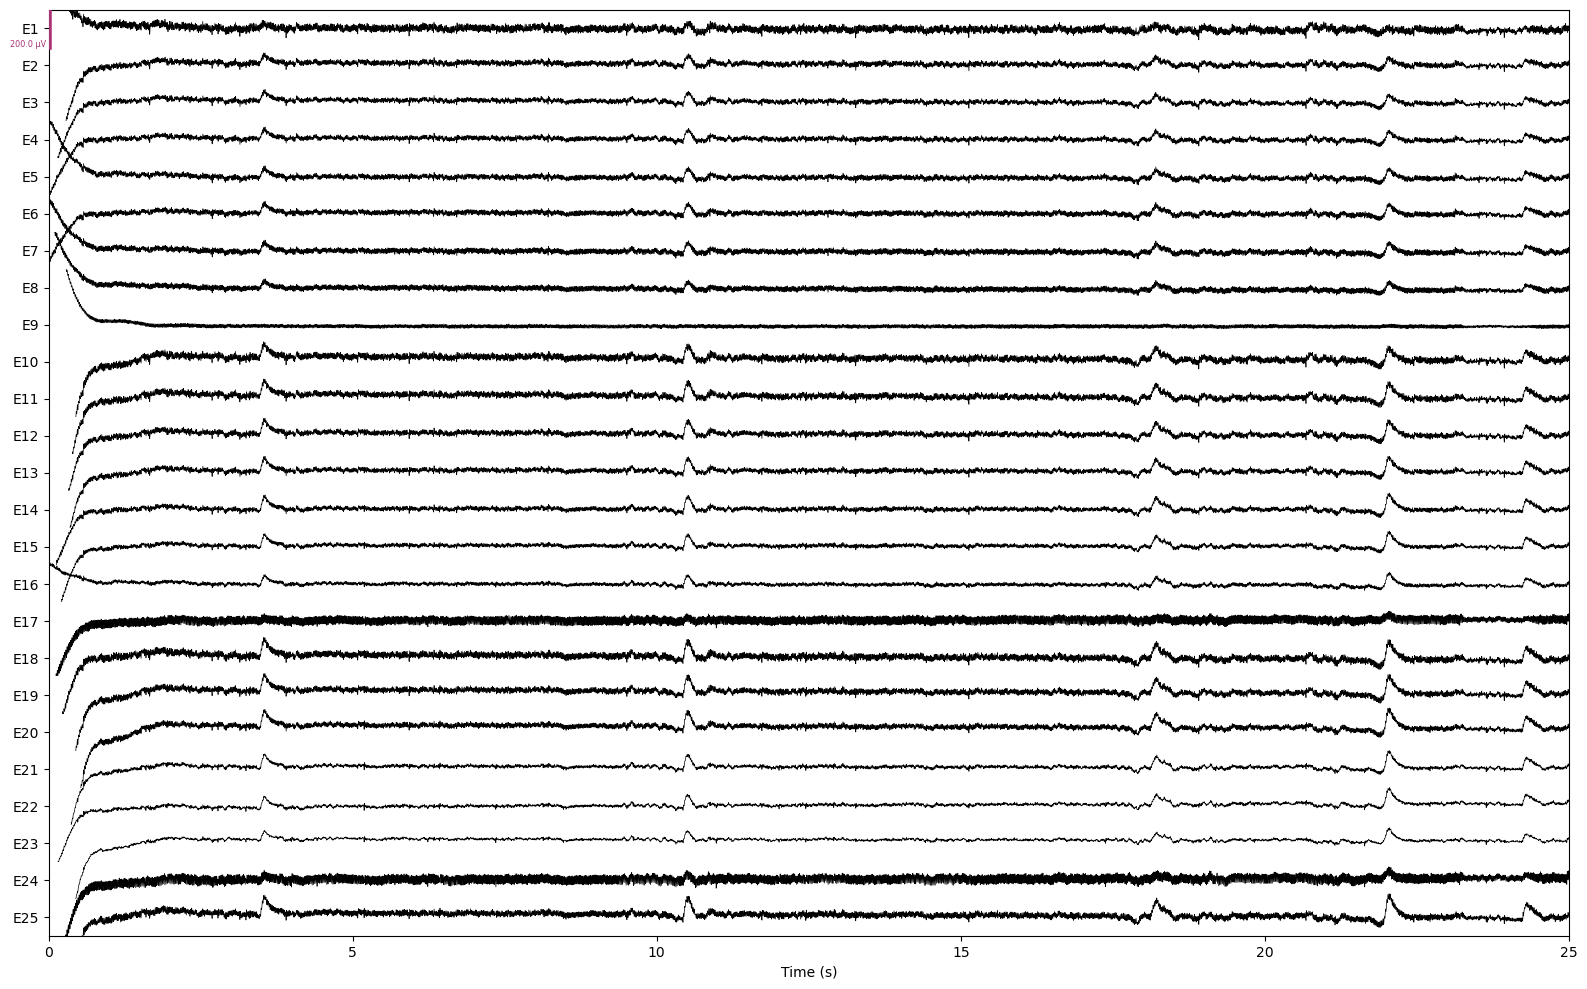

Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"256 EEG, 1 ECG"
Bad channels,VREF
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


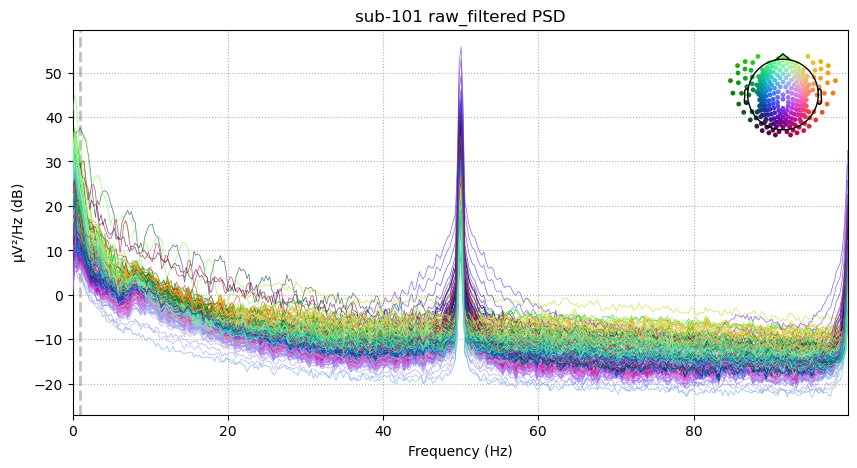

In [43]:
fline = 50
h_freq = 100
notch_freq = 50

filter_params = {
    "l_freq": 1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
}


# .notch_filter(freqs=50)  # removedrifts
# print(project_path)
raw = load_data(subject, project_path=project_path)
raw.info["bads"] = ["VREF"]
downsampled = raw.resample(500, npad=0)
# raw_detrended = detrending(downsampled, order=1)
print("Detrending done")

raw_filtered = (
    downsampled.copy().crop(tmin=2, tmax=300, include_tmax=True).filter(**filter_params)
)

plot_step(
    raw_filtered,
    subject,
    figures_path=figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

raw_filtered.info

In [44]:
iter_param = {
    "nfft": 100,
    "n_iter_max": 200,
    "win_sz": 12.5,
    "spot_sz": 6,
}
raw_zap = zapline_clean(raw_filtered, fline,
                        method="iter", iter_param=iter_param)

plot_step(
    raw_zap,
    subject,
    figures_path,
    stage="raw_zap ",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [26]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(raw_zap)
else:
    bad_channels_by_ransac = get_bad_channels(raw_zap)

raw_zap.info["bads"].extend(bad_channels_by_ransac)
raw_zap.save(
    f"{raw_preproc_path}/sub-{subject}_filtered_zap_eeg.fif", overwrite=True)
raw_zap.info

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 123
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!
Found 12 uniquely bad channels:

0 by NaN: []

0 by flat: []

1 by deviation: ['E217']

2 by HF noise: ['E216', 'E238']

11 by correlation: ['E9', 'E91', 'E132', 'E133', 'E145', 'E174', 'E216', 'E217', 'E229', 'E251', 'E256']

1 by SNR: ['E216']

0 by dropout: []

0 by RANSAC: []

bad all ['E133', 'E217', 'E9', 'E132', 'E238', 'E145', 'E91', 'E174', 'E229', 'E251', 'E216', 'E256']
Writing /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/sub-101_filtered_zap_eeg.fif
Closing /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/sub-101_filtered_zap_eeg.fif
[done]


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"244 EEG, 1 ECG"
Bad channels,"VREF, E133, E217, E9, E132, E238, E145, E91, E174, E229, E251, E216, E256"
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


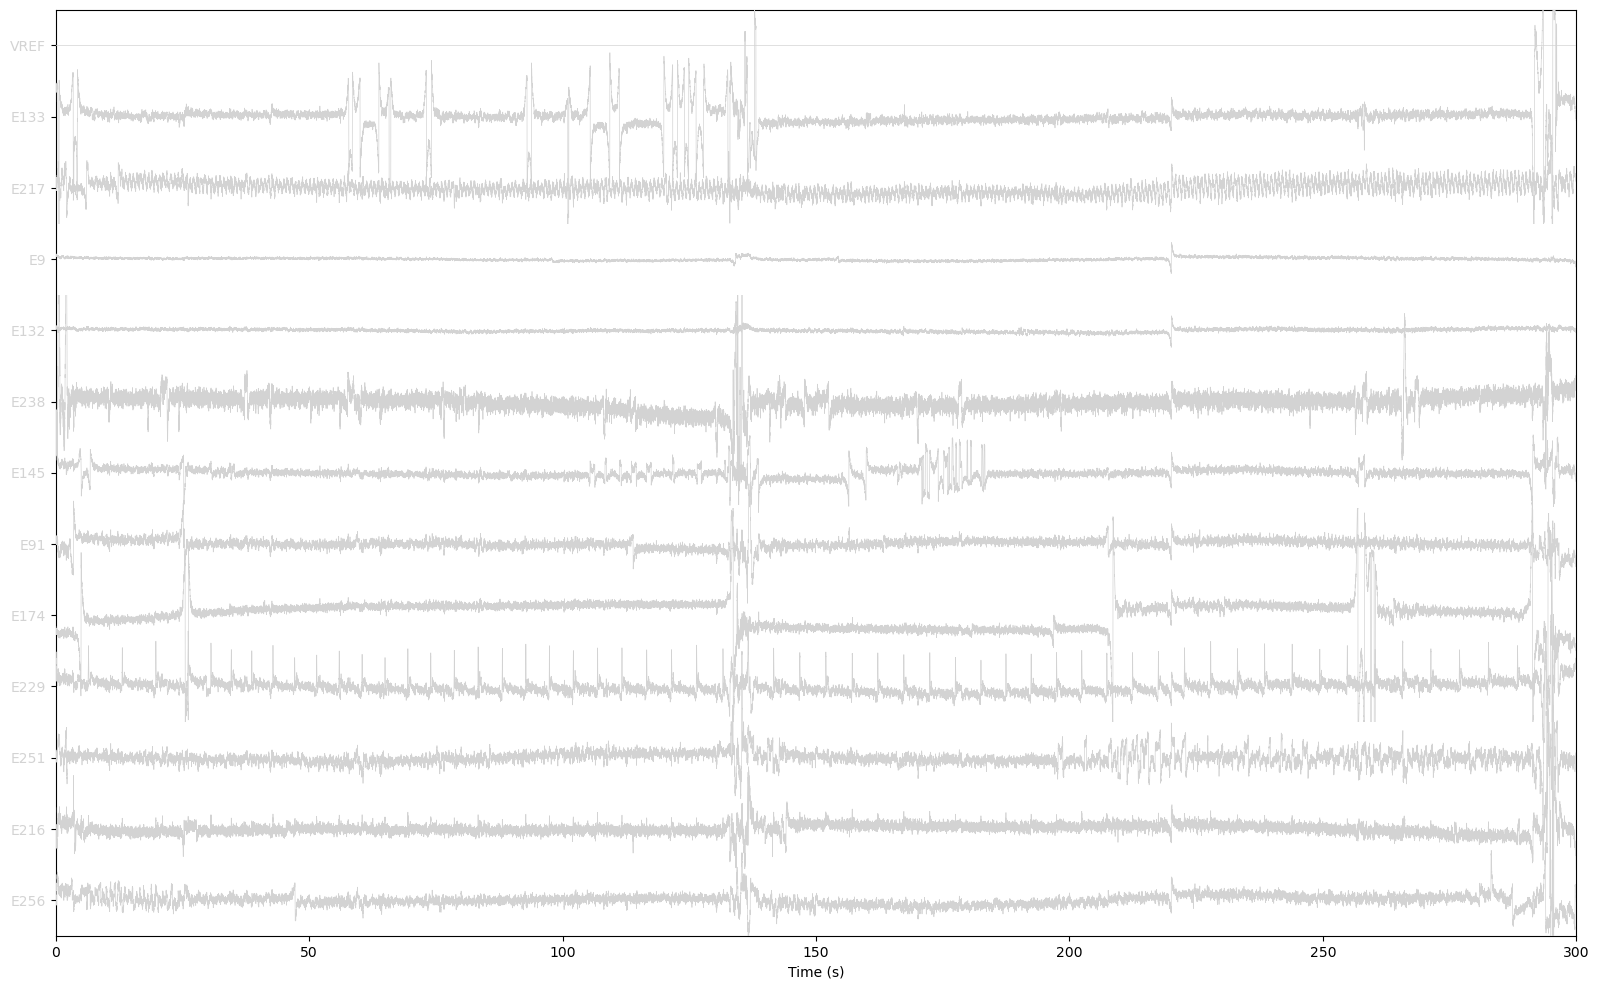

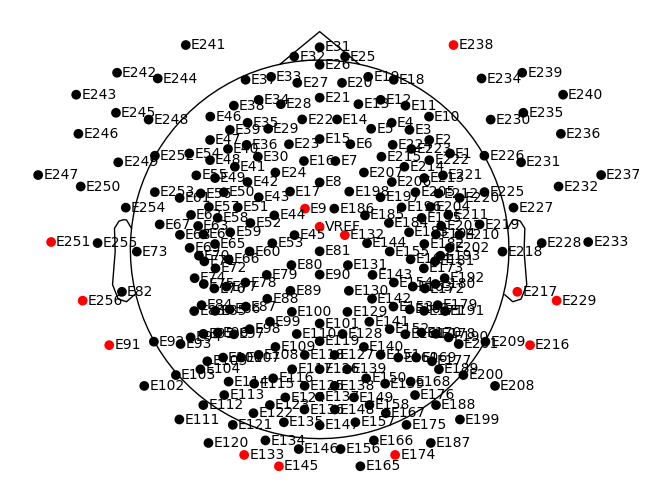

In [28]:
_ = plot_bad_channels(raw_zap, subject, figures_path=figures_path)

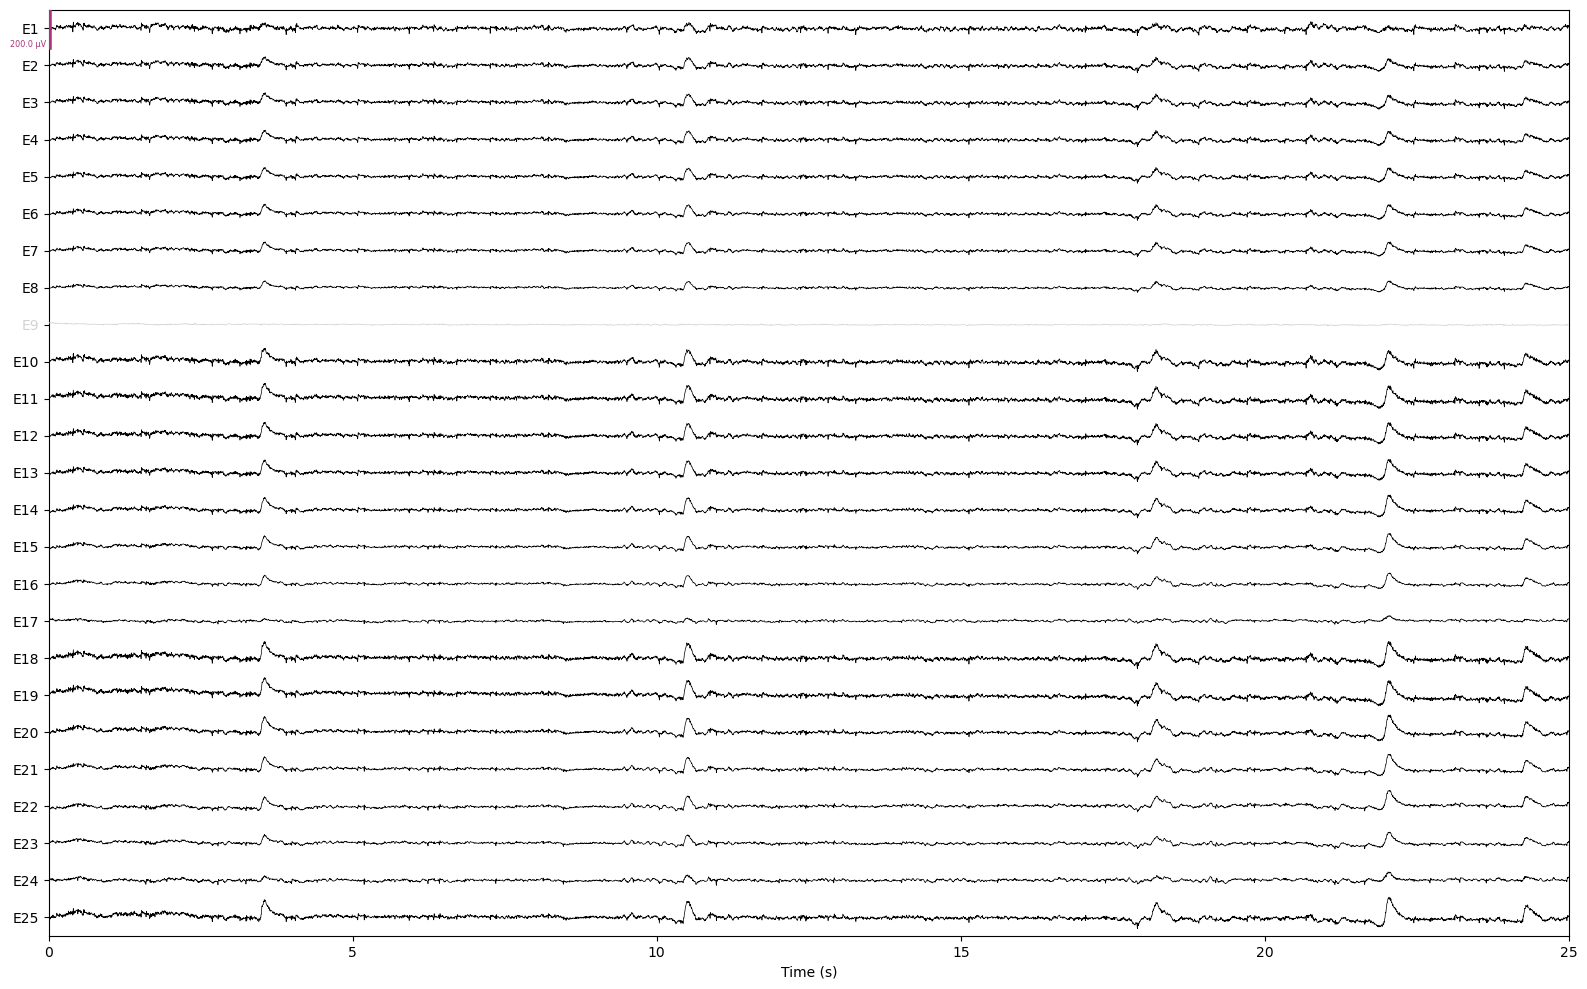

Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


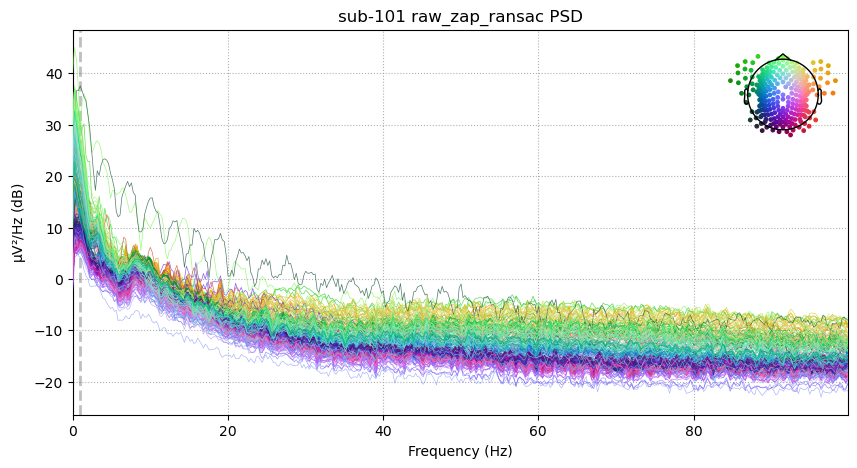

In [30]:
plot_step(
    raw_zap,
    subject,
    figures_path,
    stage="raw_zap_ransac",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [34]:
qt = True
if qt:
    with mne.viz.use_browser_backend("qt"):
        raw_zap.plot(
            start=0,
            duration=15,
            n_channels=15,
        )

Using qt as 2D backend.


2024-03-24 21:14:42,104 - qdarkstyle - INFO - QSS file successfully loaded.
2024-03-24 21:14:42,107 - qdarkstyle - INFO - Found OS patches to be applied.
2024-03-24 21:14:42,112 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-24 21:14:42,115 - qdarkstyle - INFO - Found application patches to be applied.


Using pyopengl with version 3.1.6
Using matplotlib as 2D backend.


Channels marked as bad:
['VREF', 'E133', 'E217', 'E9', 'E132', 'E238', 'E145', 'E91', 'E174', 'E229', 'E251', 'E216', 'E256']


In [35]:
print(
    f"{subject} -  identified {len(raw_zap.info['bads'])
                               }  bad channels: {raw_zap.info['bads']}"
)
print_date_time()

101 -  identified 13  bad channels: ['VREF', 'E133', 'E217', 'E9', 'E132', 'E238', 'E145', 'E91', 'E174', 'E229', 'E251', 'E216', 'E256']
2024-03-24 21:14:47
